# Garbage binary classification one vs all

In this notebook we would like to see how we can do binary classification when having multiple classes in our dataset

## Imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, RandomFlip, RandomRotation, RandomZoom, Rescaling, BatchNormalization, SpatialDropout2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle


keras.utils.set_random_seed(42)

from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Helpers
Then we will create some methods that we will use during our modeling.

In [2]:
image_size = 224

directory_path = "../v2/Garbage classification/"

We will use this to generate batches of data that we will use for training and validation.

In [4]:
def generate_for_class(labels_column, train_dataset, validation_dataset, image_size=image_size)-> tuple[ImageDataGenerator, ImageDataGenerator]:
    directory_path = "../v2/Garbage classification/"

    train_batches = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.1,
        rescale=1./255.,
        ).flow_from_dataframe(
        dataframe=train_dataset,
        x_col = 'File_path',
        y_col = labels_column,
        target_size=(image_size,image_size),shuffle=True, seed=42, class_mode='raw', batch_size=32
        )


    # extract images to validation set
    valid_batches = ImageDataGenerator(
        rescale=1./255.,
        ).flow_from_dataframe(
        dataframe=validation_dataset,
        x_col = 'File_path',
        y_col = labels_column,
        target_size=(image_size,image_size),shuffle=True, seed=42, class_mode='raw', batch_size=32,
    )


    return train_batches, valid_batches



In [5]:
def generate_batch(labels_column, dataframe, use_augmentation=False, image_size=image_size)-> tuple[ImageDataGenerator, ImageDataGenerator]:
    directory_path = "../v2/Garbage classification/"

    if use_augmentation == True:
        batches = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.1,
            rescale=1./255.,
            )

    else:
        batches = ImageDataGenerator()

    batches = batches.flow_from_dataframe(
            dataframe=dataframe,
            x_col = 'File_path',
            y_col = labels_column,
            target_size=(image_size,image_size),shuffle=True, seed=42, class_mode='raw', batch_size=32
            )

    return batches


We will have also a method for test batches.

In [6]:
def generate_test_batch_for_class(labels_column, test_dataset, image_size = image_size)-> ImageDataGenerator:
    test_batches = ImageDataGenerator(
        rescale=1./255.
        ).flow_from_dataframe(
        dataframe=test_dataset,
        x_col = 'File_path',
        y_col = labels_column, target_size=(image_size,image_size),shuffle=False, class_mode='raw', batch_size=32)

    return test_batches

In [7]:
def predict_image_with_model(image_path, model, image_size = image_size)->None:

    image = Image.open(image_path)

    image = image.resize((image_size, image_size))  # Replace 'width' and 'height' with desired dimensions

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Convert the numpy array to a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

    # Expand the dimensions of the tensor to match the expected input shape
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    print(image_tensor.shape)

    predictions = model.predict(image_tensor, verbose=0)
    print(predictions)

We will create a method to save the model when the metric is improving

In [8]:
def create_model_checkpoint(model_path, metric='val_accuracy') -> ModelCheckpoint:
    model_checkpoint = ModelCheckpoint(model_path, monitor=metric, verbose=1, save_best_only=True)
    return model_checkpoint

A method to compile our model

In [9]:
def compile_model(model, learning_rate = 0.001) -> None:
    model.compile(optimizer=Adam(learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

This will pass our batched images one by one to our model and do the predictions

In [10]:
def prediction_generator(test_images) -> tf.Tensor:
    k = 0
    for x in test_images:
        k += len(x[1])
        yield x[0], x[1]  # Passing single tensor to the model
        if k >= test_images.n:
            break


In [11]:
def split_data_evenly(df, classes_column, train_size=0.7, test_size=0.1, random_state=42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the data evenly into training, validation, and test sets.

    Parameters:
    - df: The DataFrame containing the data.
    - classes_column: The name of the column containing classes.
    - train_size: The proportion of the dataset to include in the training set.
    - test_size: The proportion of the dataset to include in the test set.
    - random_state: The seed used by the random number generator.

    Returns:
    - A tuple containing three DataFrames: train_data, validation_data, and test_data.
    """

    # Split the data into training and the rest, stratifying by class labels
    train_data, rest_data = train_test_split(df, train_size=train_size, stratify=df[classes_column], random_state=random_state)

    # Calculate the remaining percentage
    remaining_size = 1.0 - train_size

    # Split the remaining data into testing and evaluation, stratifying by class labels
    valid_data, test_data = train_test_split(rest_data, test_size=test_size/remaining_size, stratify=rest_data[classes_column], random_state=random_state)

    return train_data, valid_data, test_data

This will process every image and return some metadata about it

In [12]:
def get_image_metadata(df_row)->tuple[int, int, str, str]:
    file_path = os.path.join(directory_path, df_row['Class'], df_row['File_name'])
    image = Image.open(file_path)
    width, height = image.size
    channels = image.mode
    return width, height, image.format, channels

This will plot the confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(actual_classes, predicted_classes, classes={0,1}) -> None:
    class_=classes
    cm = confusion_matrix(actual_classes, predicted_classes)

    print(cm)

    fig = plt.figure(figsize=(6, 4))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu");
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Actual', fontsize=20)
    ax.yaxis.set_ticklabels(class_, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('', fontsize=60)

    plt.show()

This is a custom data loader. It will convert our dataframe into batches of tensors

In [14]:
def custom_data_loader(dataframe, labels_column, batch_size, image_size):

    file_paths = file_paths = dataframe.File_path.tolist()  # List of file paths
    labels = dataframe[labels_column].tolist()

    file_paths, labels = shuffle(file_paths, labels, random_state=42)

    for i in range(0, len(file_paths), batch_size):
        batch_file_paths = file_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        batch_images = []
        for file_path in batch_file_paths:

            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(image_size, image_size))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img / 255.

            batch_images.append(img)

        yield np.array(batch_images), np.array(batch_labels)

This will send our dataframe to the custom loader and we will get the batches of data

In [15]:
def load_dataset(dataframe, labels_column, batch_size = 32, image_size=image_size):

    dataset = tf.data.Dataset.from_generator(
        lambda: custom_data_loader(dataframe, labels_column, batch_size, image_size),
        output_types=(tf.float32, tf.int32),
        output_shapes=(tf.TensorShape([None, image_size, image_size, 3]), tf.TensorShape([None]))
        )

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

This will allow us to visualize the images used in the training

In [16]:
class ImageVisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_dataset, val_dataset, num_images_to_visualize=2):
        super(ImageVisualizationCallback, self).__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.num_images_to_visualize = num_images_to_visualize

    def visualize_dataset(self, dataset, title):
        iterator = iter(dataset)
        for _ in range(self.num_images_to_visualize):
            image, _ = next(iterator)
            augmented_image = self.model.layers[0](image, training=True)
            augmented_image = augmented_image[0]*255
            image = image[0] * 255

            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(image.numpy().astype("uint8"))
            plt.title("Original Image")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(augmented_image.numpy().astype("uint8"))
            plt.title("Augmented Image")
            plt.axis("off")
            plt.suptitle(title)
            plt.show()

    def on_epoch_end(self, epoch, logs=None):
        self.visualize_dataset(self.train_dataset, "Training Set")
        self.visualize_dataset(self.val_dataset, "Validation Set")



## Dataset processing

We are getting the folders from our images directory

In [17]:
def list_folders_in_directory(directory)-> list[str]:
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

directory_path = directory_path
folders_list = list_folders_in_directory(directory_path)
print(folders_list)

['metal', 'cardboard', 'plastic', 'trash', 'paper', 'glass']


We are using the folder list to create a dataframe with the class, the name and the path for every file that we have in those folders

In [18]:
data = []
for folder in folders_list:
    files = os.listdir(os.path.join(directory_path, folder))
    #Add each file along with its folder name to the data list
    for file in files:
        data.append({'Class': folder, 'File_name': file, 'File_path':os.path.join(directory_path, folder, file)})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
df.head()



,Class,File_name,File_path
0,metal,metal68.jpg,/content/Garbage classification/metal/metal68.jpg
1,metal,metal66.jpg,/content/Garbage classification/metal/metal66.jpg
2,metal,metal336.jpg,/content/Garbage classification/metal/metal336...
3,metal,metal150.jpg,/content/Garbage classification/metal/metal150...
4,metal,metal242.jpg,/content/Garbage classification/metal/metal242...


We are getting more details about our files

In [19]:
df['Image_width'], df['Image_height'], df['Image_format'], df['Image_channel'] = zip(*df.apply(get_image_metadata, axis=1))

df.head()

,Class,File_name,File_path,Image_width,Image_height,Image_format,Image_channel
0,metal,metal68.jpg,/content/Garbage classification/metal/metal68.jpg,225,225,JPEG,RGB
1,metal,metal66.jpg,/content/Garbage classification/metal/metal66.jpg,512,384,JPEG,RGB
2,metal,metal336.jpg,/content/Garbage classification/metal/metal336...,512,384,JPEG,RGB
3,metal,metal150.jpg,/content/Garbage classification/metal/metal150...,512,384,JPEG,RGB
4,metal,metal242.jpg,/content/Garbage classification/metal/metal242...,512,384,JPEG,RGB


We are looking at the format of our data.

It seems that we do not have any unusual formats.

In [20]:
df['Image_format'].value_counts()

Image_format
JPEG    6472
PNG       28
Name: count, dtype: int64

We are looking at the channel type.

In [21]:
df.Image_channel.value_counts()

Image_channel
RGB    6472
P        28
Name: count, dtype: int64

We will drop everything that does not have the *RGB* channel

In [22]:
df = df.drop(df[df.Image_channel != 'RGB'].index)

In [23]:
df.Image_channel.value_counts()

Image_channel
RGB    6472
Name: count, dtype: int64

In [24]:
all_glass_df = df.copy()

We can take a look on how many images we have in our classes.

In [25]:
df.Class.value_counts()

Class
glass        2010
paper        1047
cardboard     891
plastic       865
metal         849
trash         810
Name: count, dtype: int64

Because we want to do a binary classification on a class vs the rest of the classes, we need to hot encode our classes.

In [26]:
one_hot_encoded = pd.get_dummies(df.Class, dtype=int)
df = pd.concat([df, one_hot_encoded] , axis=1)

df.head()

,Class,File_name,File_path,Image_width,Image_height,Image_format,Image_channel,cardboard,glass,metal,paper,plastic,trash
0,metal,metal68.jpg,/content/Garbage classification/metal/metal68.jpg,225,225,JPEG,RGB,0,0,1,0,0,0
1,metal,metal66.jpg,/content/Garbage classification/metal/metal66.jpg,512,384,JPEG,RGB,0,0,1,0,0,0
2,metal,metal336.jpg,/content/Garbage classification/metal/metal336...,512,384,JPEG,RGB,0,0,1,0,0,0
3,metal,metal150.jpg,/content/Garbage classification/metal/metal150...,512,384,JPEG,RGB,0,0,1,0,0,0
4,metal,metal242.jpg,/content/Garbage classification/metal/metal242...,512,384,JPEG,RGB,0,0,1,0,0,0


We can drop the columns that we will not use in our model

In [27]:
df = df.drop(columns=['Image_width', 'Image_height', 'Image_format', 'Image_channel'])

df.head()

,Class,File_name,File_path,cardboard,glass,metal,paper,plastic,trash
0,metal,metal68.jpg,/content/Garbage classification/metal/metal68.jpg,0,0,1,0,0,0
1,metal,metal66.jpg,/content/Garbage classification/metal/metal66.jpg,0,0,1,0,0,0
2,metal,metal336.jpg,/content/Garbage classification/metal/metal336...,0,0,1,0,0,0
3,metal,metal150.jpg,/content/Garbage classification/metal/metal150...,0,0,1,0,0,0
4,metal,metal242.jpg,/content/Garbage classification/metal/metal242...,0,0,1,0,0,0


## Splitting the data

Now we want to split our data into train, validation and test.

We will split the data evenly based on the class with the method from Helpers section.

In [28]:
training_df, validation_df, test_df = split_data_evenly(df, 'Class')

training_df.Class.value_counts(normalize=True), validation_df.Class.value_counts(normalize=True), test_df.Class.value_counts(normalize=True)

(Class
 glass        0.310596
 paper        0.161810
 cardboard    0.137748
 plastic      0.133554
 metal        0.131126
 trash        0.125166
 Name: proportion, dtype: float64,
 Class
 glass        0.310665
 paper        0.161515
 cardboard    0.137558
 plastic      0.133694
 metal        0.131376
 trash        0.125193
 Name: proportion, dtype: float64,
 Class
 glass        0.310185
 paper        0.162037
 cardboard    0.137346
 plastic      0.134259
 metal        0.131173
 trash        0.125000
 Name: proportion, dtype: float64)

Then we can reset our index for our new dataframes

In [29]:
training_df.reset_index(drop=True,inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True,inplace=True)

## Classification models

First we need to decide what image size we want to use.

Then we can define the layers for our model.

- the input will be of our image size(height and width are the same) and the number of color channels 3(RGB)
- the output will be a single value that should be between 0 and 1. That is why *sigmoid* function is used.

In [30]:
pre_processing_data = Sequential([
    RandomFlip("horizontal", input_shape=(image_size, image_size, 3)),
    RandomFlip("vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

In [31]:
layers = [
    pre_processing_data,
    Conv2D(16, (3, 3), padding='same', activation='relu',input_shape=(image_size, image_size, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1, activation = 'sigmoid')
    ]


## Cardboard model - SMOTENC resampler

Because we are having an imbalanced dataset between the cardboard and the other classes, we need to use a method to fix this.

We chose SMOTE resampler for this case.

### SMOTENC resampler

SMOTENC stands for Synthetic Minority Over-sampling Technique for Nominal and Continuous features. It is an extension of the SMOTE algorithm, which is used for oversampling in imbalanced classification problems. SMOTENC is specifically designed to handle datasets with both numerical (continuous) and categorical (nominal) features.

In [32]:
from imblearn.over_sampling import SMOTENC

def oversample_on_class(dataframe, column_name) -> pd.DataFrame:
    non_numeric_columns_index = dataframe.select_dtypes(exclude='number').columns
    non_numeric_columns_index_list = dataframe.columns.get_indexer(non_numeric_columns_index).tolist()

    # Define SMOTENC sampler
    sm = SMOTENC(categorical_features=non_numeric_columns_index_list, random_state=42, sampling_strategy='minority', k_neighbors=100)

    # Separate features and target
    X = dataframe.drop([column_name], axis=1)  # Features
    y = dataframe[column_name]  # Target column you want to oversample

    # Perform oversampling using SMOTENC
    oversampled_X, oversampled_y = sm.fit_resample(X, y)

    # Convert oversampled data to DataFrame
    oversampled_df = pd.DataFrame(oversampled_X, columns=X.columns)
    oversampled_df[column_name] = oversampled_y

    return oversampled_df

In [33]:
cardboard_training_df = oversample_on_class(training_df, 'cardboard')

We can check that we have duplicated data in our oversampled dataframe

In [34]:
cardboard_training_df.File_name.value_counts()

File_name
cardboard814.jpg      48
cardboard710.jpg      48
cardboard51.jpg       46
cardboard7.jpg        46
cardboard110.jpg      44
                      ..
plastic504.jpg         1
metal306.jpg           1
trash29 (2).jpg        1
white-glass695.jpg     1
plastic342.jpg         1
Name: count, Length: 4530, dtype: int64

We will generate our batches of data that we will use in training our model

For this we will use a method that we created in the Helpers area

In [35]:
cardboard_training_ds = load_dataset(cardboard_training_df, 'cardboard')
cardboard_validation_ds = load_dataset(validation_df, 'cardboard')

We will create our model and compile it

In [36]:
cardboard_model = Sequential(layers)
compile_model(cardboard_model)

Then we are ready to train the model

In [37]:
cardboard_model_path = '../models/cardboard_model.h5'
cardboard_history = cardboard_model.fit(x=cardboard_training_ds, validation_data=cardboard_validation_ds, epochs=50, callbacks=[create_model_checkpoint(cardboard_model_path)])

Epoch 1/50
    245/Unknown - 21s 56ms/step - loss: 0.2909 - precision: 0.9003 - recall: 0.8689 - accuracy: 0.8863
Epoch 1: val_accuracy improved from -inf to 0.94436, saving model to ../models/cardboard_model.h5
245/245 [==============================] - 23s 67ms/step - loss: 0.2909 - precision: 0.9003 - recall: 0.8689 - accuracy: 0.8863 - val_loss: 0.1740 - val_precision: 0.7624 - val_recall: 0.8652 - val_accuracy: 0.9444
Epoch 2/50
243/245 [============================>.] - ETA: 0s - loss: 0.2353 - precision: 0.9107 - recall: 0.9166 - accuracy: 0.9135
Epoch 2: val_accuracy did not improve from 0.94436
245/245 [==============================] - 7s 28ms/step - loss: 0.2346 - precision: 0.9110 - recall: 0.9171 - accuracy: 0.9137 - val_loss: 0.1882 - val_precision: 0.7368 - val_recall: 0.8652 - val_accuracy: 0.9389
Epoch 3/50
243/245 [============================>.] - ETA: 0s - loss: 0.1923 - precision: 0.9315 - recall: 0.9377 - accuracy: 0.9344
Epoch 3: val_accuracy did not improve from

After that we will evaluate our model with the help of a confusion matrix

In [38]:
from sklearn.metrics import accuracy_score

def get_actual_vs_predictions(column_name, model_path, dataframe = test_df):
    test_batches = generate_test_batch_for_class(column_name, dataframe)
    model = tf.keras.models.load_model(model_path)

    probabilities = model.predict(prediction_generator(test_batches))
    predicted_classes = (probabilities > 0.5).astype(int)
    actual_classes = test_batches.labels

    print("Accuracy :", accuracy_score(actual_classes, predicted_classes))

    return actual_classes, predicted_classes

Found 648 validated image filenames.
21/21 [==============================] - 1s 57ms/step
Accuracy : 0.9521604938271605
[[546  13]
 [ 18  71]]


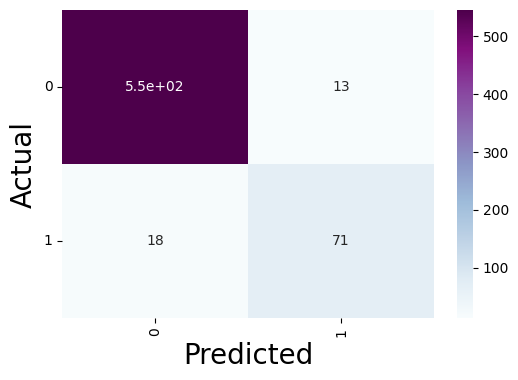

In [39]:
actual_classes, predicted_classes = get_actual_vs_predictions('cardboard', cardboard_model_path)
plot_confusion_matrix(actual_classes, predicted_classes)

## Class weights

### Paper model

How to handle imbalanced classes with class weights

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [40]:
paper_class_weights = compute_class_weight('balanced', classes=np.unique(training_df.paper), y=training_df.paper)

paper_class_weights_dict = dict(enumerate(paper_class_weights))
paper_class_weights_dict

{0: 0.596523571240453, 1: 3.0900409276944067}

We are preparing the datasets and compiling a paper model

In [41]:
paper_train_ds = load_dataset(training_df, 'paper')
paper_valid_ds = load_dataset(validation_df, 'paper')

paper_model = Sequential(layers)
compile_model(paper_model)

And training the paper model

In [42]:
paper_model_path = '../models/paper_model.h5'
history = paper_model.fit(x=paper_train_ds, validation_data=paper_valid_ds, class_weight = paper_class_weights_dict,epochs=50, callbacks=[create_model_checkpoint(paper_model_path)])

Epoch 1/50
    142/Unknown - 10s 53ms/step - loss: 0.6488 - precision_1: 0.3082 - recall_1: 0.7626 - accuracy: 0.6845
Epoch 1: val_accuracy improved from -inf to 0.85317, saving model to ../models/paper_model.h5
142/142 [==============================] - 13s 71ms/step - loss: 0.6488 - precision_1: 0.3082 - recall_1: 0.7626 - accuracy: 0.6845 - val_loss: 0.3295 - val_precision_1: 0.5348 - val_recall_1: 0.6986 - val_accuracy: 0.8532
Epoch 2/50
141/142 [============================>.] - ETA: 0s - loss: 0.4090 - precision_1: 0.4344 - recall_1: 0.8395 - accuracy: 0.7974
Epoch 2: val_accuracy improved from 0.85317 to 0.89026, saving model to ../models/paper_model.h5
142/142 [==============================] - 4s 30ms/step - loss: 0.4085 - precision_1: 0.4347 - recall_1: 0.8404 - accuracy: 0.7974 - val_loss: 0.2560 - val_precision_1: 0.6683 - val_recall_1: 0.6364 - val_accuracy: 0.8903
Epoch 3/50
141/142 [============================>.] - ETA: 0s - loss: 0.3520 - precision_1: 0.4842 - recall_1

We can take a look on how the results are looking

Found 648 validated image filenames.
21/21 [==============================] - 1s 44ms/step
Accuracy : 0.9197530864197531
[[513  30]
 [ 22  83]]


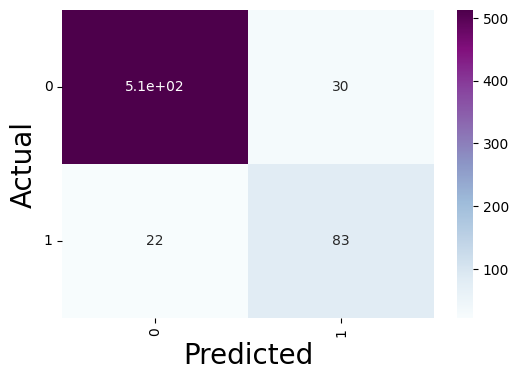

In [43]:
actual_classes, predicted_classes = get_actual_vs_predictions('paper', paper_model_path)
plot_confusion_matrix(actual_classes, predicted_classes)

### Plastic model

We are calculating the weights ratio for the plastic class

In [44]:
plastic_class_weights = compute_class_weight('balanced', classes=np.unique(training_df.plastic), y=training_df.plastic)

plastic_class_weights_dict = dict(enumerate(plastic_class_weights))
plastic_class_weights_dict

{0: 0.5770700636942675, 1: 3.743801652892562}

Preparing the dataset and compiling model

In [45]:
plastic_train_ds = load_dataset(training_df, 'plastic')
plastic_valid_ds = load_dataset(validation_df, 'plastic')

plastic_model = Sequential(layers)
compile_model(plastic_model)

Training the plastic model

In [46]:
plastic_model_path = '../models/plastic_model.h5'
history = plastic_model.fit(x=plastic_train_ds, validation_data=plastic_valid_ds, class_weight=plastic_class_weights_dict, epochs=50, callbacks=[create_model_checkpoint(plastic_model_path)])

Epoch 1/50
    141/Unknown - 9s 46ms/step - loss: 0.7398 - precision_2: 0.1951 - recall_2: 0.6822 - accuracy: 0.5829
Epoch 1: val_accuracy improved from -inf to 0.81066, saving model to ../models/plastic_model.h5
142/142 [==============================] - 12s 62ms/step - loss: 0.7392 - precision_2: 0.1966 - recall_2: 0.6843 - accuracy: 0.5843 - val_loss: 0.4506 - val_precision_2: 0.3435 - val_recall_2: 0.4566 - val_accuracy: 0.8107
Epoch 2/50
140/142 [============================>.] - ETA: 0s - loss: 0.5500 - precision_2: 0.2675 - recall_2: 0.7525 - accuracy: 0.6920
Epoch 2: val_accuracy improved from 0.81066 to 0.84003, saving model to ../models/plastic_model.h5
142/142 [==============================] - 4s 29ms/step - loss: 0.5478 - precision_2: 0.2689 - recall_2: 0.7537 - accuracy: 0.6934 - val_loss: 0.3564 - val_precision_2: 0.4227 - val_recall_2: 0.5376 - val_accuracy: 0.8400
Epoch 3/50
141/142 [============================>.] - ETA: 0s - loss: 0.5629 - precision_2: 0.2739 - recal

Checking the results

Found 648 validated image filenames.
21/21 [==============================] - 1s 46ms/step
Accuracy : 0.9089506172839507
[[534  27]
 [ 32  55]]


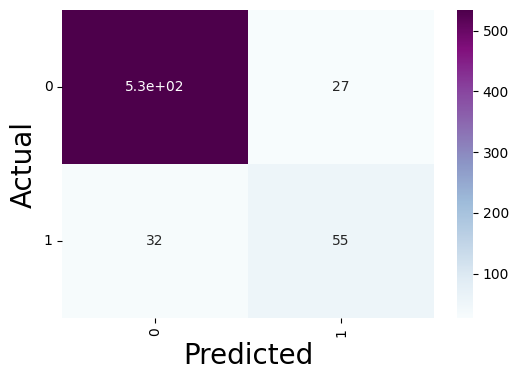

In [47]:
actual_classes, predicted_classes = get_actual_vs_predictions('plastic', plastic_model_path)
plot_confusion_matrix(actual_classes, predicted_classes)

### Metal model

We are calculating the weights ratio for the metal class

In [48]:
metal_class_weights = compute_class_weight('balanced', classes=np.unique(training_df.metal), y=training_df.metal)

metal_class_weights_dict = dict(enumerate(metal_class_weights))
metal_class_weights_dict

{0: 0.5754573170731707, 1: 3.813131313131313}

Preparing the dataset and compiling model

In [49]:
metal_train_ds = load_dataset(oversample_on_class(training_df, 'metal'), 'metal')
metal_valid_ds = load_dataset(validation_df, 'metal')

metal_model = Sequential(layers)
compile_model(metal_model)

Checking the results

In [50]:
metal_model_path = '../models/metal_model.h5'
history = metal_model.fit(x=metal_train_ds, validation_data=metal_valid_ds, epochs=50, callbacks=[create_model_checkpoint(metal_model_path)])

Epoch 1/50
    246/Unknown - 16s 53ms/step - loss: 0.5649 - precision_3: 0.6877 - recall_3: 0.7238 - accuracy: 0.6975
Epoch 1: val_accuracy improved from -inf to 0.72566, saving model to ../models/metal_model.h5
246/246 [==============================] - 18s 63ms/step - loss: 0.5649 - precision_3: 0.6877 - recall_3: 0.7238 - accuracy: 0.6975 - val_loss: 0.5345 - val_precision_3: 0.2921 - val_recall_3: 0.7647 - val_accuracy: 0.7257
Epoch 2/50
245/246 [============================>.] - ETA: 0s - loss: 0.4491 - precision_3: 0.7646 - recall_3: 0.8158 - accuracy: 0.7827
Epoch 2: val_accuracy improved from 0.72566 to 0.78594, saving model to ../models/metal_model.h5
246/246 [==============================] - 7s 29ms/step - loss: 0.4486 - precision_3: 0.7653 - recall_3: 0.8168 - accuracy: 0.7832 - val_loss: 0.4448 - val_precision_3: 0.3449 - val_recall_3: 0.7000 - val_accuracy: 0.7859
Epoch 3/50
245/246 [============================>.] - ETA: 0s - loss: 0.3890 - precision_3: 0.8025 - recall_3

Checking the results

Found 648 validated image filenames.
21/21 [==============================] - 1s 46ms/step
Accuracy : 0.9151234567901234
[[531  32]
 [ 23  62]]


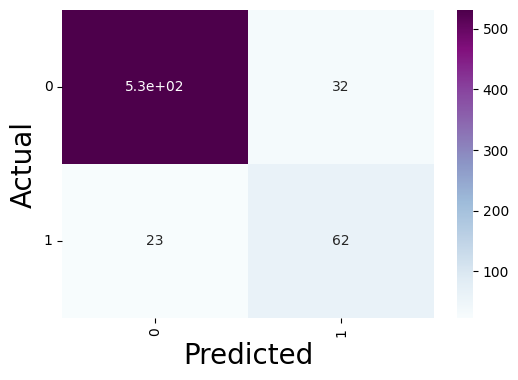

In [51]:
actual_classes, predicted_classes = get_actual_vs_predictions('metal', metal_model_path)
plot_confusion_matrix(actual_classes, predicted_classes)

### Trash model

Doing the same steps for trash model

In [52]:
trash_class_weights = compute_class_weight('balanced', classes=np.unique(training_df.trash), y=training_df.trash)

trash_class_weights_dict = dict(enumerate(trash_class_weights))
trash_class_weights_dict

{0: 0.5715367146101439, 1: 3.994708994708995}

In [53]:
trash_train_ds = load_dataset(training_df, 'trash')
trash_valid_ds = load_dataset(validation_df, 'trash')

trash_model = Sequential(layers)
compile_model(trash_model)

In [54]:
trash_model_path = '../models/trash_model.h5'
history = trash_model.fit(x=trash_train_ds, validation_data=trash_valid_ds, class_weight=trash_class_weights_dict, epochs=50, callbacks=[create_model_checkpoint(trash_model_path)])

Epoch 1/50
    142/Unknown - 10s 46ms/step - loss: 0.6702 - precision_4: 0.3570 - recall_4: 0.6032 - accuracy: 0.8143
Epoch 1: val_accuracy improved from -inf to 0.82844, saving model to ../models/trash_model.h5
142/142 [==============================] - 12s 62ms/step - loss: 0.6702 - precision_4: 0.3570 - recall_4: 0.6032 - accuracy: 0.8143 - val_loss: 0.5001 - val_precision_4: 0.3958 - val_recall_4: 0.7037 - val_accuracy: 0.8284
Epoch 2/50
141/142 [============================>.] - ETA: 0s - loss: 0.4841 - precision_4: 0.4104 - recall_4: 0.6714 - accuracy: 0.8378
Epoch 2: val_accuracy improved from 0.82844 to 0.83230, saving model to ../models/trash_model.h5
142/142 [==============================] - 4s 29ms/step - loss: 0.4838 - precision_4: 0.4099 - recall_4: 0.6702 - accuracy: 0.8380 - val_loss: 0.4405 - val_precision_4: 0.4021 - val_recall_4: 0.6975 - val_accuracy: 0.8323
Epoch 3/50
140/142 [============================>.] - ETA: 0s - loss: 0.5988 - precision_4: 0.4030 - recall_4

Found 648 validated image filenames.
21/21 [==============================] - 1s 44ms/step
Accuracy : 0.8935185185185185
[[522  45]
 [ 24  57]]


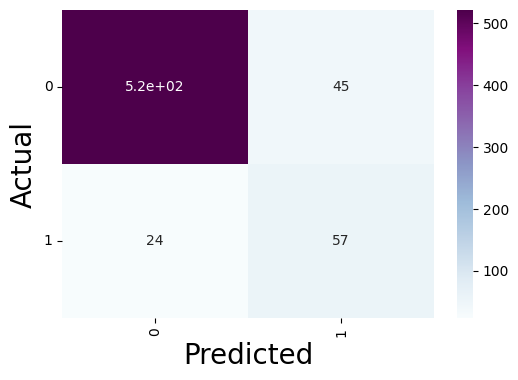

In [55]:
actual_classes, predicted_classes = get_actual_vs_predictions('trash', trash_model_path)
plot_confusion_matrix(actual_classes, predicted_classes)

## Undersampling

We are creating a method that will randomly undersample our majority class to balance our data

In [56]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

def randomly_undersampling_df(column_class, dataframe) -> pd.DataFrame:
    # Define features (X) and target (y)
    X = dataframe.drop(column_class, axis=1)  # Features
    y = dataframe[column_class]  # Target variable

    # Define Random Undersampler
    undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

    # Fit and apply the undersampling method to your dataset
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Convert the undersampled data back to a DataFrame
    undersampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    undersampled_df[column_class] = y_resampled

    return undersampled_df

### Glass undersampling

We are undersampling the glass data

In [57]:
undersample_glass_df = randomly_undersampling_df('glass', df)

undersample_glass_df.glass.value_counts()

glass
0    2010
1    2010
Name: count, dtype: int64

Then we are splitting the data into train, validation and test

In [58]:
undersample_glass_train, undersample_glass_valid, undersample_glass_test = split_data_evenly(undersample_glass_df, classes_column='glass')

Loading the data and compiling the model

In [59]:
glass_train_ds = load_dataset(undersample_glass_train, 'glass')
glass_valid_ds = load_dataset(validation_df, 'glass')

glass_model = Sequential(layers)
compile_model(glass_model)

Training the model

In [60]:
glass_model_path = '../models/glass_model.h5'
undersample_glass_history = glass_model.fit(x=glass_train_ds, validation_data=glass_valid_ds, epochs=50, callbacks=[create_model_checkpoint(glass_model_path)])

Epoch 1/50
     88/Unknown - 8s 61ms/step - loss: 0.7756 - precision_5: 0.6582 - recall_5: 0.5693 - accuracy: 0.6368
Epoch 1: val_accuracy improved from -inf to 0.72179, saving model to ../models/glass_model.h5
88/88 [==============================] - 10s 88ms/step - loss: 0.7756 - precision_5: 0.6582 - recall_5: 0.5693 - accuracy: 0.6368 - val_loss: 0.5468 - val_precision_5: 0.5451 - val_recall_5: 0.6318 - val_accuracy: 0.7218
Epoch 2/50
86/88 [============================>.] - ETA: 0s - loss: 0.5027 - precision_5: 0.7519 - recall_5: 0.7208 - accuracy: 0.7409
Epoch 2: val_accuracy improved from 0.72179 to 0.78053, saving model to ../models/glass_model.h5
88/88 [==============================] - 3s 31ms/step - loss: 0.5013 - precision_5: 0.7506 - recall_5: 0.7228 - accuracy: 0.7413 - val_loss: 0.4871 - val_precision_5: 0.6234 - val_recall_5: 0.7413 - val_accuracy: 0.7805
Epoch 3/50
87/88 [============================>.] - ETA: 0s - loss: 0.4726 - precision_5: 0.7873 - recall_5: 0.7324 

Checking the results

Found 648 validated image filenames.
21/21 [==============================] - 1s 54ms/step
Accuracy : 0.8842592592592593
[[414  33]
 [ 42 159]]


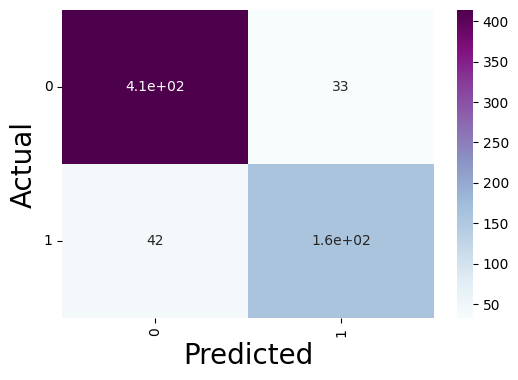

In [61]:
actual_classes, predicted_classes = get_actual_vs_predictions('glass', glass_model_path)
plot_confusion_matrix(actual_classes, predicted_classes)

## Multilabel predictions

Loading our saved models

In [62]:
cardboard_loaded_model = tf.keras.models.load_model("../models/cardboard_model.h5")
glass_loaded_model = tf.keras.models.load_model("../models/glass_model.h5")
paper_loaded_model = tf.keras.models.load_model("../models/paper_model.h5")
metal_loaded_model = tf.keras.models.load_model("../models/metal_model.h5")
plastic_loaded_model = tf.keras.models.load_model("../models/plastic_model.h5")
trash_loaded_model = tf.keras.models.load_model("../models/trash_model.h5")

loaded_models =[cardboard_loaded_model,glass_loaded_model,paper_loaded_model,metal_loaded_model,plastic_loaded_model,trash_loaded_model]


In [92]:
def get_one_vs_all_predictions(column_name, models, dataframe = test_df):
    test_batches = generate_test_batch_for_class(column_name, dataframe)

    models = models
    predictions = []
    actual_classes = test_batches.labels

    for model in models:

        model_predictions = model.predict(prediction_generator(test_batches))
        predictions.append(model_predictions)

    return predictions, actual_classes

It is important to have the label columns in the same order as the models

In [100]:
label_columns = ["cardboard", "glass", "paper", "metal", "plastic", "trash"]
predictions, actual_classes = get_one_vs_all_predictions(label_columns, loaded_models)

Found 648 validated image filenames.
21/21 [==============================] - 1s 51ms/step


We can check how our expected classes look like

In [101]:
actual_classes

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]])

We are removing the single dimensional entries from the array of predicted outputs

In [102]:
for i in range(len(predictions)):
    predictions[i] = np.squeeze(predictions[i])

Now we need to combine the predictions in a single matrix and then indentify the index for the highest prediction

In [103]:
combined_predictions = np.vstack(predictions).T

combined_predictions.shape

final_predictions = np.argmax(combined_predictions, axis=1)
final_predictions

array([4, 1, 5, 5, 3, 1, 3, 3, 5, 0, 0, 1, 1, 4, 4, 1, 1, 5, 1, 3, 1, 0,
       5, 1, 2, 2, 1, 1, 4, 1, 1, 1, 3, 3, 0, 1, 2, 1, 1, 2, 4, 1, 1, 1,
       2, 3, 2, 0, 5, 1, 4, 0, 2, 1, 0, 5, 1, 3, 3, 0, 5, 5, 1, 0, 1, 1,
       2, 3, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 0, 3, 5, 5, 2, 2, 2, 1, 3, 1,
       1, 0, 0, 1, 5, 3, 5, 3, 3, 1, 1, 1, 0, 0, 2, 3, 2, 0, 1, 1, 1, 3,
       0, 4, 4, 5, 0, 2, 1, 2, 5, 1, 2, 5, 5, 1, 0, 3, 2, 3, 3, 5, 0, 3,
       3, 3, 5, 1, 5, 3, 5, 0, 4, 0, 4, 2, 2, 2, 2, 1, 1, 1, 1, 5, 1, 1,
       1, 0, 5, 4, 1, 1, 5, 5, 1, 0, 5, 1, 1, 3, 4, 2, 2, 5, 5, 1, 1, 5,
       2, 0, 2, 0, 3, 2, 1, 2, 1, 2, 1, 1, 4, 0, 1, 1, 5, 1, 2, 2, 0, 1,
       1, 1, 0, 2, 2, 1, 1, 3, 0, 1, 3, 4, 1, 3, 4, 5, 1, 4, 4, 1, 5, 1,
       5, 4, 4, 3, 4, 0, 0, 5, 5, 0, 2, 1, 0, 4, 1, 5, 1, 0, 5, 3, 5, 3,
       3, 1, 5, 0, 4, 1, 1, 2, 5, 2, 2, 4, 0, 0, 1, 5, 4, 3, 1, 2, 1, 4,
       0, 3, 2, 0, 3, 4, 2, 4, 3, 5, 2, 1, 1, 5, 0, 0, 1, 3, 0, 0, 1, 1,
       5, 4, 4, 3, 1, 5, 2, 4, 0, 0, 1, 1, 0, 0, 2,

We need to get the index of the expected class

In [104]:
final_actual = np.argmax(actual_classes, axis=1)
final_actual

array([5, 4, 5, 5, 3, 1, 3, 3, 1, 0, 0, 1, 5, 4, 4, 1, 1, 5, 1, 3, 1, 0,
       5, 1, 1, 2, 1, 1, 4, 1, 1, 1, 3, 3, 0, 1, 0, 1, 1, 2, 4, 1, 0, 1,
       2, 3, 2, 0, 2, 4, 1, 0, 2, 1, 0, 3, 1, 3, 3, 0, 5, 5, 1, 0, 1, 1,
       2, 3, 1, 2, 1, 1, 5, 1, 1, 2, 2, 2, 0, 3, 5, 0, 2, 2, 5, 1, 4, 3,
       1, 0, 0, 2, 4, 3, 5, 5, 3, 1, 1, 1, 0, 0, 2, 3, 2, 1, 1, 3, 1, 3,
       1, 4, 4, 5, 0, 0, 1, 2, 4, 1, 2, 5, 5, 1, 0, 3, 2, 3, 3, 5, 5, 2,
       3, 3, 5, 1, 5, 2, 4, 0, 4, 0, 4, 2, 1, 2, 2, 1, 5, 4, 1, 5, 1, 1,
       1, 4, 5, 4, 1, 1, 4, 5, 4, 0, 5, 5, 1, 3, 2, 2, 2, 5, 2, 1, 5, 5,
       2, 0, 2, 0, 3, 2, 1, 2, 1, 2, 1, 1, 4, 0, 1, 1, 1, 3, 2, 2, 0, 1,
       1, 1, 3, 2, 2, 1, 4, 1, 4, 1, 3, 4, 1, 3, 4, 5, 1, 4, 4, 1, 4, 1,
       5, 4, 4, 3, 4, 0, 0, 4, 1, 0, 2, 1, 0, 2, 1, 5, 1, 0, 5, 3, 5, 3,
       3, 1, 5, 0, 1, 1, 1, 2, 5, 4, 2, 4, 1, 0, 3, 5, 3, 4, 1, 0, 1, 4,
       0, 3, 0, 0, 0, 4, 4, 4, 3, 5, 2, 1, 1, 5, 0, 1, 1, 4, 0, 0, 1, 1,
       5, 2, 4, 3, 1, 5, 2, 4, 0, 0, 1, 0, 0, 0, 2,

Then we are plotting a confusion matrix between the actual and predicted classes

[[ 78   4   4   1   0   2]
 [  6 167   7   3   9   9]
 [  0   4  90   4   5   2]
 [  1   7   2  70   3   2]
 [  2  11   3   5  53  13]
 [  2   7   5   6   4  57]]


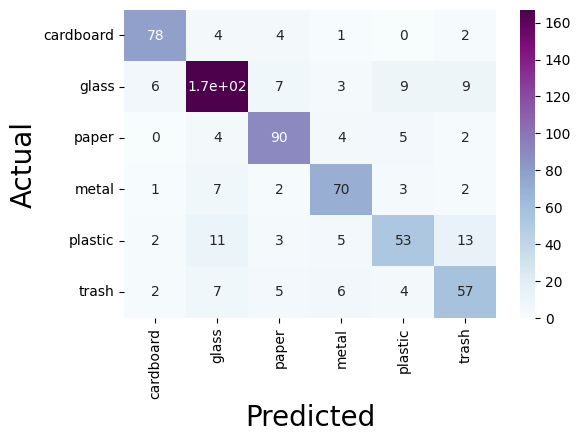

In [105]:
plot_confusion_matrix(actual_classes=final_actual, predicted_classes=final_predictions, classes=label_columns)